This notebook will highlight the features of the pharmacophore featurizers 2D and 3D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import datamol as dm
import pandas as pd

from molfeat.calc import Pharmacophore2D
from molfeat.calc import Pharmacophore3D

[11:16:01] /opt/dgl/src/runtime/tensordispatch.cc:Using backend: pytorch
43: TensorDispatcher: dlopen failed: /home/hadim/local/conda/envs/molfeat/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.8.0.post3.so: cannot open shared object file: No such file or directory


## Pharmacophore 2D

The pharmacophore 2D featurizer is similar to any other molfeat featurizers.

- The `factory` argument decides how the features are detected. You can choose from `"default", "cats", "gobbi" , "pmapper"` but you can also directly pass and RDKit `MolChemicalFeatureFactory` object or a path to a feature definition file.
- `length` allows you to set the length of the fingerprint. It's 2048 by default. If set to None, the default depends on the `factory` used. We strongly recommend using a fixed length. But you should also check for collision and adapt the length for it. Usually, 2048 is a good tradeoff.
- Finally, you can set any parameters for the signature factory. Check the docstring for more details.
  - `useCounts`
  - `minPointCount`
  - `maxPointCount`
  - `shortestPathsOnly`
  - `includeBondOrder`
  - `skipFeats`
  - `trianglePruneBins`
  - `bins`

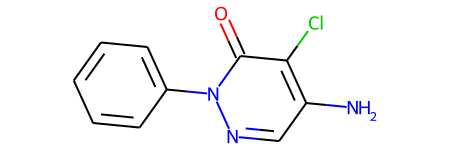

In [3]:
# Get a molecule
mol = dm.to_mol("Nc1cnn(-c2ccccc2)c(=O)c1Cl")

mol

In [5]:
# Create the featurizer
featurizer = Pharmacophore2D(factory="pmapper", length=2048)

print(len(featurizer))

# Computing a fingerprint
fp = featurizer(mol)

print(fp.shape)
fp

2048
(2048,)


array([0., 1., 0., ..., 0., 0., 0.])

## Pharmacophore 3D

The pharmacophore 3D featurizer is different from the 2D featurizer:

- It requires the molecules to have conformer.
- It allows extracting pharmacophoric features as dataframe.
- It ships a couple of 3D viz features.
- It supports building a consensus features list and fingerprint.

### Regular one-molecule featurizer

In this section we are going to extract the feature for one molecule, compute the associated fingerprint and finally visualize the features in 3D.

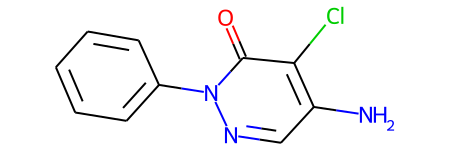

In [6]:
# Get a molecule
mol = dm.to_mol("Nc1cnn(-c2ccccc2)c(=O)c1Cl")
mol = dm.conformers.generate(mol, n_confs=1)

# Build a conformer

mol

Note that `bin_step` is an important parameter that influence the "bluriness" of your pharmacophoric features. It will also impact the true size of the fingerprint and so also influences fingerprint collision when `length` is provided.

In [7]:
# Create the featurizer
featurizer = Pharmacophore3D(factory="pmapper", length=2048, bin_step=1)

# Extract the features
features = featurizer.get_features(mol)

features

,feature_id,feature_name,feature_type,atom_indices,coords
0,1,a,ar6,"(1, 2, 3, 4, 11, 13)","[1.6073308945212306, -0.36478682508765736, 0.1..."
1,2,a,ar6,"(5, 6, 7, 8, 9, 10)","[-2.5373606040975885, 0.26569516099436263, -0...."
2,3,D,N_HBD,"(0,)","[4.374047166053936, -0.7628191630259037, 0.243..."
3,4,A,N_HBA,"(3,)","[0.7699593756605752, -1.3098389937058816, 0.56..."
4,5,A,O_HBA,"(12,)","[0.6258053493478449, 1.8317635297679282, -0.79..."
5,6,H,ar6_hyd,"(1, 2, 3, 4, 11, 13)","[1.6073308945212306, -0.36478682508765736, 0.1..."
6,7,H,ar6_hyd,"(5, 6, 7, 8, 9, 10)","[-2.5373606040975885, 0.26569516099436263, -0...."
7,8,H,hyd_1,"(14,)","[3.501330026469845, 1.8924330558014002, -0.888..."


The extracted features are returned as a dataframe.

Next is to compute the associated fingerprint.

In [8]:
# Compute a fingerprint for a molecule
fp = featurizer(mol)

print(fp.shape)
print(fp.sum())
fp

(2048,)
76


array([1, 0, 0, ..., 0, 0, 0])

It's also possible to visualize the features.

In [9]:
# Show the conformer with the pharmacophoric features
featurizer.show(mol, show_legend=True)

The 3D viz is not available in the documentation. Here is a screenshot.

![pharm_3d_one_mol.png.png](./images/pharm_3d_one_mol.png)

### Consensus pharmacophore

A consensus pharamacophore combine multiple molecules together and build a list of features using a clustering approach.

First we start with a list of similar molecules.

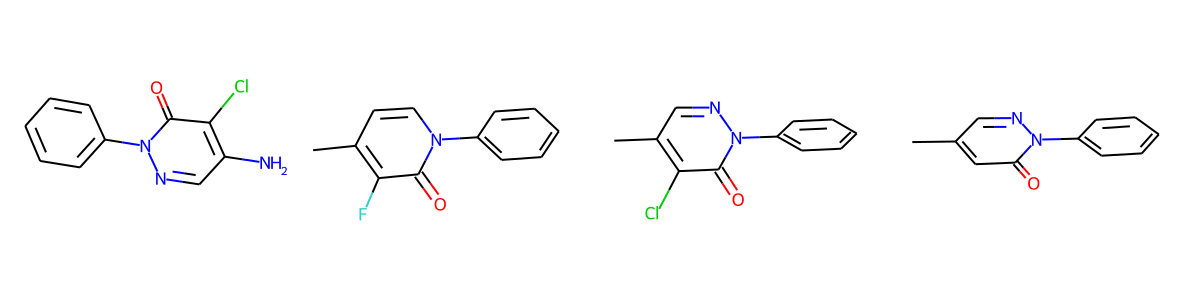

In [10]:
# First generate conformers for our list of molecules
smiles_list = [
    "Nc1cnn(-c2ccccc2)c(=O)c1Cl",
    "Cc1ccn(-c2ccccc2)c(=O)c1F",
    "Cc1cnn(-c2ccccc2)c(=O)c1Cl",
    "Cc1cnn(-c2ccccc2)c(=O)c1",
]
mols = [dm.to_mol(smiles) for smiles in smiles_list]
mols = [dm.conformers.generate(mol, n_confs=1) for mol in mols]

dm.to_image(mols)

You will notice that while similar the conformers are not aligned with respect to each other.

In that specific example, since the conformers are not aligned, the features extraction will run an alignment step first. You can (and should) disable that step if your molecules already contains conformer of interest (such as poses for examples).

In [11]:
# Initialize the featurizer
featurizer = Pharmacophore3D(factory="pmapper", bin_step=1, length=2048)

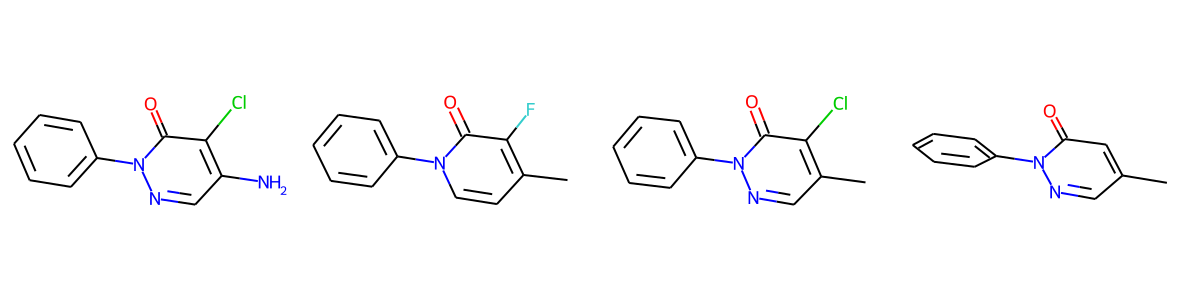

In [12]:
# Extract all the features from a list of molecules
features = featurizer.get_features_from_many(mols, align=True, keep_mols=True)

# Extract the aligned molecules (optional)
mols = features.groupby("mol_index").first()["mol"].tolist()

# Visualize the aligned mols
dm.to_image(mols)

Notice the returned molecules are aligned. This is those conformers that are actually used for the features clustering.

Now let's have a look at the extracted features. Note that those features **are not clustered yet.**

In [13]:
features

,feature_id,feature_name,feature_type,atom_indices,coords,mol_index,mol
0,1,a,ar6,"(1, 2, 3, 4, 11, 13)","[1.6073308945212306, -0.36478682508765736, 0.1...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,2,a,ar6,"(5, 6, 7, 8, 9, 10)","[-2.5373606040975885, 0.2656951609943626, -0.0...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,3,D,N_HBD,"(0,)","[4.374047166053936, -0.7628191630259036, 0.243...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,4,A,N_HBA,"(3,)","[0.7699593756605752, -1.3098389937058816, 0.56...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,5,A,O_HBA,"(12,)","[0.6258053493478449, 1.8317635297679282, -0.79...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
5,6,H,ar6_hyd,"(1, 2, 3, 4, 11, 13)","[1.6073308945212306, -0.36478682508765736, 0.1...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
6,7,H,ar6_hyd,"(5, 6, 7, 8, 9, 10)","[-2.5373606040975885, 0.2656951609943626, -0.0...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
7,8,H,hyd_1,"(14,)","[3.501330026469845, 1.8924330558014002, -0.888...",0,"<img data-content=""rdkit/molecule"" src=""data:i..."
8,1,a,ar6,"(1, 2, 3, 4, 11, 13)","[1.6472469847044522, -0.33346691994497213, 0.1...",1,"<img data-content=""rdkit/molecule"" src=""data:i..."
9,2,a,ar6,"(5, 6, 7, 8, 9, 10)","[-2.537205754107394, 0.27521012778383225, -0.0...",1,"<img data-content=""rdkit/molecule"" src=""data:i..."


Now we can cluster those features. Here we do it manually but all those steps are performed automatically when you are computing the fingerprint.

Two parameteres are important here:

- `min_samples_ratio` decides the minimum percentage of points in a cluster to consider it as valid.
- `eps` set the maximum distance between two feature points for one to be considered as in the neighborhood of the other.

Those parameters will **drastically** influence the returned consensus features and so the computed fingerprint.

In [14]:
# Cluster the features
clustered_features = featurizer.cluster_features(
    features,
    min_samples_ratio=0.75,
    eps=1,
)

clustered_features

,feature_id,feature_name,coords,cluster_size
0,0,A,"[0.7542705995570907, -1.2265609293202056, 0.66...",3
1,1,A,"[0.6244082027004373, 1.8049171959076213, -0.90...",4
2,2,H,"[1.6143325565814577, -0.34309376877266595, 0.1...",4
3,3,H,"[-2.5509231346184205, 0.262642542748756, -0.01...",4
4,4,H,"[3.4442852582035672, 1.8000142617866193, -0.84...",3
5,5,H,"[4.4730273625331956, -0.7548342221913047, 0.23...",3
6,6,a,"[1.6143325565814577, -0.34309376877266595, 0.1...",4
7,7,a,"[-2.5509231346184205, 0.262642542748756, -0.01...",4


Much less features are now returned. Not that `cluster_size` tell you how many feature points have participated to the associated consensus feature point. You can eventually use it as a "weight" in downstream application.

Now, let's compute the consensus fingerprint.

In [15]:
consensus_fp = featurizer.consensus_fp(mols, align=True, eps=1, min_samples_ratio=0.5)

print(consensus_fp.shape)
print(consensus_fp.sum())
consensus_fp

(2048,)
69


array([1, 0, 0, ..., 0, 0, 0])

You can also visualize the clustered features as well as the list of molecules used for the consensus.

In [16]:
featurizer.show_many(mols, align=True, eps=1, min_samples_ratio=0.5, show_legend=True)

The 3D viz is not available in the documentation. Here is a screenshot.

![pharm_3d_consensus.png](./images/pharm_3d_consensus.png)

### Distance from the consensus fingerprint

Here we compute the Jaccard distances from the computed consensus fingerprint.

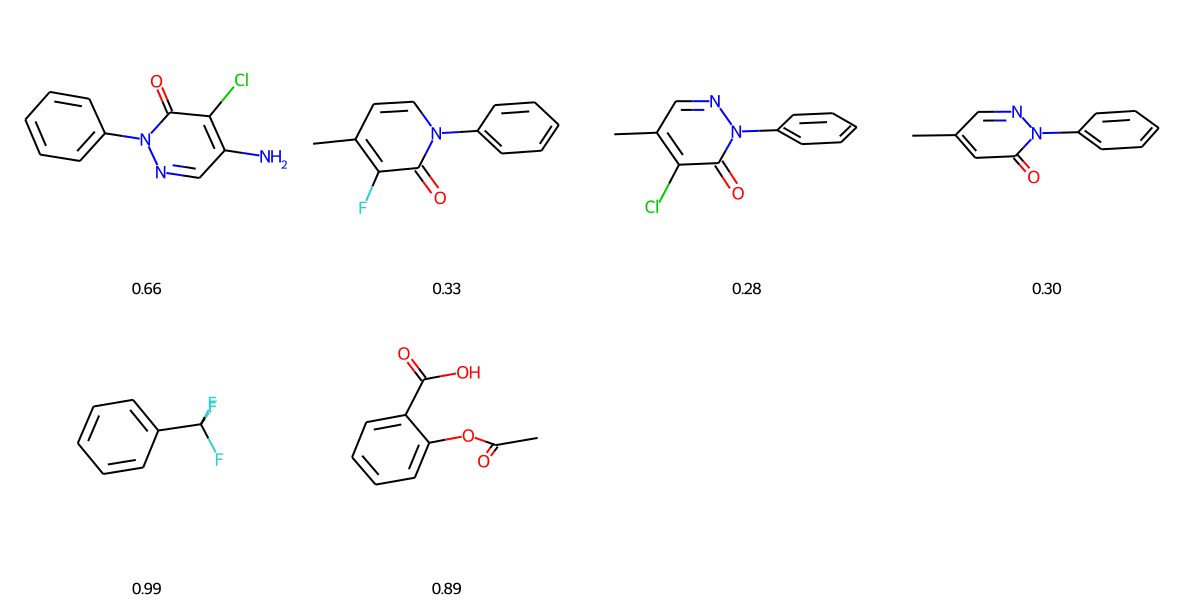

In [18]:
from scipy.spatial.distance import cdist

smiles_list = [
    "Nc1cnn(-c2ccccc2)c(=O)c1Cl",
    "Cc1ccn(-c2ccccc2)c(=O)c1F",
    "Cc1cnn(-c2ccccc2)c(=O)c1Cl",
    "Cc1cnn(-c2ccccc2)c(=O)c1",
    "c1ccc(cc1)C(F)(F)F",
    "CC(=O)OC1=CC=CC=C1C(=O)O"
]
mols = [dm.to_mol(smiles) for smiles in smiles_list]
mols = [dm.conformers.generate(mol, n_confs=1) for mol in mols]

fps = [featurizer(mol) for mol in mols]

distances = cdist([consensus_fp], fps, metric="jaccard")

dm.to_image(mols, legends=[f"{d:.2f}" for d in distances[0]])

Playing with the various consensus parameters will give you different distances.